In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-06-27 19:52:27.705035: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 19:52:27.797625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 19:52:28.399401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def datacleaning_amazon():
    dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
    train_data = dataset['train']

    # Limit the dataset to the first 10,000 rows
    train_data = train_data.select(range(10000))

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
    df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
    df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
    df.set_index('customer_id', inplace=True)

    df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(model, dataloader_train, dataloader_val, epochs):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(range(1, epochs + 1), training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(range(1, epochs + 1), validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(range(1, epochs + 1), f1_score_list, label='F1 Score')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()

        # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, epochs + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_amazon()

Using the latest cached version of the module from /home/z123010/.cache/huggingface/modules/datasets_modules/datasets/amazon_us_reviews/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563 (last modified on Tue May 23 19:43:32 2023) since it couldn't be found locally at amazon_us_reviews., or remotely on the Hugging Face Hub.
Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
39856338,Best No slip socks I've ever owned,Four out of five pairs are perfect. One pair d...,4,good,0,val
25914116,Four Stars,ok,4,good,0,train
439146,Three Stars,Expected for the logo to be more original,3,neutral,1,train
37398528,Just what I wanted,"Just what I wanted - a nice, thin credit card ...",5,good,0,train
44593047,Three Stars,returned,3,neutral,1,val
26403334,I love them.,"For the price, these are soft and fit well and...",5,good,0,train
7158905,absolutely LOVE to cute,Super cute! If you're an alternative chick thi...,5,good,0,train
47427058,Better than I could have imagined,This wallet is everything they say it is. Afte...,5,good,0,train
20692814,Very nice !!,"A very nice dress, I bought this dress for my ...",5,good,0,train


In [6]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment
star_rating label data_type                                         
1           2     train                  932          932        932
                  val                    163          163        163
2           2     train                  459          459        459
                  val                    101          101        101
3           1     train                  682          682        682
                  val                    137          137        137
4           0     train                 1307         1307       1307
                  val                    278          278        278
5           0     train                 4620         4620       4620
                  val                   1321         1321       1321

In [7]:
# Load BERT tokenizer
pretrained_path = 'gpt2'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(8000, 2000)

In [9]:
from transformers import GPT2Model, GPT2Config

num_classes = 6

class SentimentModel(nn.Module):
    def __init__(self, pretrained_path, num_classes, rcnn_hidden_size):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(            
            pretrained_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.1)
        self.gpt = GPT2Model.from_pretrained(pretrained_path, config=gpt_config)
        
        self.dropout = nn.Dropout(0.2)
        self.conv = nn.Conv1d(gpt_config.hidden_size, rcnn_hidden_size, kernel_size=3, padding=1)
        self.fc = nn.Linear(2 * rcnn_hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        
        output = torch.cat((gpt_last_hidden_state,), dim=1)

        conv_input = output.unsqueeze(2)

        # Apply convolution operation
        conv_output = self.conv(conv_input)
        conv_output = nn.functional.relu(conv_output)

        # Max pooling operation
        max_pooled = torch.max(conv_output, dim=2)[0]

        # Average pooling operation
        avg_pooled = torch.mean(conv_output, dim=2)

        # Concatenate max and average pooled features
        concatenated = torch.cat((max_pooled, avg_pooled), dim=1)

        logits = self.fc(concatenated)
        outputs = nn.functional.softmax(logits, dim=1)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [10]:
# Create model instance
pretrained_path = "gpt2"
rcnn_hidden_size = 256
model = SentimentModel(pretrained_path, num_classes, rcnn_hidden_size)

In [11]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (conv): Conv1d(768, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=512, out_features=6, bias=True)
)

In [12]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [18]:
def train_model(trainer, dataloader_train, dataloader_val, epochs):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_rcnn_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(range(1, epochs + 1), training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(range(1, epochs + 1), validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(range(1, epochs + 1), f1_score_list, label='F1 Score')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()

    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, epochs + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6161592205036431
Validation loss: 0.34754384532570837
F1 Score (weighted): 0.873275890823952


Epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.38344377193273976
Validation loss: 0.32072725241887384
F1 Score (weighted): 0.8840289110246844
37.77% Training loss decreased compared to the previous epoch
7.72% Validation loss decreased compared to the previous epoch
1.23% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.34175506548408885
Validation loss: 0.3121933542563347
F1 Score (weighted): 0.8939010879582134
10.87% Training loss decreased compared to the previous epoch
2.66% Validation loss decreased compared to the previous epoch
1.12% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.31477604476065607
Validation loss: 0.2902887968912255
F1 Score (weighted): 0.9049052543032919
7.89% Training loss decreased compared to the previous epoch
7.02% Validation loss decreased compared to the previous epoch
1.23% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2870571629864571
Validation loss: 0.28252189538965466
F1 Score (weighted): 0.9123800568658748
8.81% Training loss decreased compared to the previous epoch
2.68% Validation loss decreased compared to the previous epoch
0.83% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.26922820675349796
Validation loss: 0.3271771974339499
F1 Score (weighted): 0.9044205465778846
6.21% Training loss decreased compared to the previous epoch
15.81% Validation loss increased compared to the previous epoch
0.87% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.2515852654071787
Validation loss: 0.333280057380136
F1 Score (weighted): 0.9137832885832489
6.55% Training loss decreased compared to the previous epoch
1.87% Validation loss increased compared to the previous epoch
1.04% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.2340122885167657
Validation loss: 0.3379865592860006
F1 Score (weighted): 0.908901559977394
6.98% Training loss decreased compared to the previous epoch
1.41% Validation loss increased compared to the previous epoch
0.53% F1 Score decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.21733321915254056
Validation loss: 0.33899319340812506
F1 Score (weighted): 0.9108458358742743
7.13% Training loss decreased compared to the previous epoch
0.3% Validation loss increased compared to the previous epoch
0.21% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.22679206275354227
Validation loss: 0.3545376087186742
F1 Score (weighted): 0.9096306590764045
4.35% Training loss increased compared to the previous epoch
4.59% Validation loss increased compared to the previous epoch
0.13% F1 Score decreased compared to the previous epoch

Total training time: 51.26322373549144 minutes
Final Accuracy: 0.9115
Final Precision: 0.9095161035643795


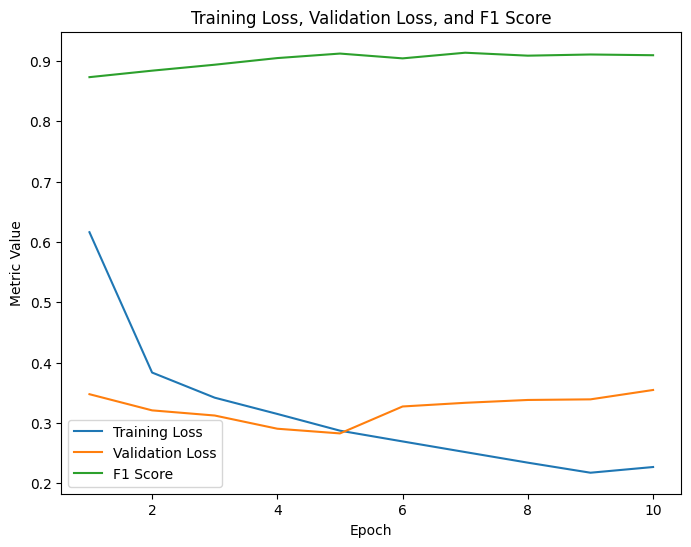

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy      Precision
--------------------  -------------------  -------------------  ------------------  ----------  -----------
1                     0.6161592205036431   0.34754384532570837  0.873275890823952   0.8865         0.891375
2                     0.38344377193273976  0.32072725241887384  0.8840289110246844  0.8945         0.905398
3                     0.34175506548408885  0.3121933542563347   0.8939010879582134  0.9055         0.897624
4                     0.31477604476065607  0.2902887968912255   0.9049052543032919  0.9095         0.902386
5                     0.2870571629864571   0.28252189538965466  0.9123800568658748  0.9175         0.912061
6                     0.26922820675349796  0.3271771974339499   0.9044205465778846  0.909          0.904073
7                     0.2515852654071787   0.333280057380136    0.9137832885832489  0.9185         0.912784
8                     0.2340

In [19]:
train_model(trainer, dataloader_train, dataloader_val, epochs)